# Spatial Imaging dv/v
spatial imaging by means of a diffusion-based sensitivity kernel (see Obermann, et al., 2013 and Pacheco and Snieder, 2005)

Implementation here is just for the 2D case

## Sensitivity Kernel

In [2]:
import numpy as np

from matplotlib import pyplot as plt


def probability(
    dist: np.ndarray | float, t: float, vel: float,
        mf_path: float) -> np.ndarray | float:
    """
    Compute the probability for a wave with the given properties to pass
    through a point at distance `dist`. Following the diffusion law.

    Implementation as in Obermann et al. (2013).

    :param dist: distance to the source. Can be a matrix.
    :type dist: np.ndarray | float
    :param t: time
    :type t: float
    :param vel: velocity for homogeneous velocities
    :type vel: float
    :param mf_path: Mean free path of the wave.
    :type mf_path: float
    :return: The probability. In the same shape as ``dist``.
    :rtype: np.ndarray | float
    """
    coherent = np.nan_to_num(
        np.exp(-vel*t/mf_path)/(2*np.pi*dist), nan=0, posinf=1)
    coherent *= np.isclose(dist, vel*t, atol=1e-4)
    a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
    b = (np.sqrt((vel*t)**2-dist**2) - vel*t)/mf_path
    c = np.heaviside(vel*t-dist, 1)
    # Sensitivity is zero where nan
    return coherent + np.nan_to_num(np.exp(b)*c/a, posinf=1, neginf=1, nan=0)


def compute_grid_dist(
        x: np.ndarray, y: np.ndarray, x0: float, y0: float) -> np.ndarray:
    """
    Compute the distance of each point on the grid x, y to x0, y0.
    (2D)

    :param x: X coordinate axis
    :type x: np.ndarray
    :param y: y coordiante axis
    :type y: np.ndarray
    :param x0: x-position of point
    :type x0: float
    :param y0: y-position of point
    :type y0: float
    :return: distance matrix in form of a 2D matrix.
    :rtype: np.ndarray
    """
    X, Y = np.meshgrid(x-x0, y-y0)
    return np.sqrt(X**2 + Y**2)


def sensitivity_kernel(
    s1: np.ndarray, s2: np.ndarray, x: np.ndarray, y: np.ndarray, t: float,
        dt: float,  vel: float, mf_path: float) -> np.ndarray:
    """
    Computes a 2D diffusion lawsurface-wave sensitivity kernel for an
    ambient noise cross-correlation between two station ``s1`` and ``s2``.

    Implementation as in Obermann et al. (2013). Limits for inf and nan
    will return 0, or 1 respectively.

    .. note::
        A large ``dt`` can lead to artefacts in the kernel.

    :param s1: Position of Station 1, format is [x, y].
    :type s1: np.ndarray
    :param s2: Position of Station 2, format is [x, y].
    :type s2: np.ndarray
    :param x: Monotonously increasing array holding the x-coordinates of the
        grid the kernel should be computed on.
    :type x: np.ndarray
    :param y: Monotonously increasing array holding the y-coordinates of the
        grid the kernel should be computed on.
    :type y: np.ndarray
    :param t: Time of coda that is probed. Usually set as the middle of the
        used time window
    :type t: float
    :param dt: Sampling interval that the probability will be computed in.
        Note that dt should not be too large. Otherwise, numerical artefacts
        can occur.
    :type dt: float
    :param vel: Surface wave velocity. Note that units between coordinate grid
        and velocity have to be consistent (i.e., km/s and km or m and m/s)
    :type vel: float
    :param mf_path: Mean free path of the wave (see Obermann et al. 2013 for
        details)
    :type mf_path: float
    :return: The sensitivity_kernel of the grid. Can be plotted against.\
        np.meshgrid(x, y)
    :rtype: np.ndarray
    """
    T = np.arange(0, t + dt, dt)
    dist_s1_s2 = np.linalg.norm(s1-s2)
    denom = probability(dist_s1_s2, t, vel, mf_path)
    dist_s1_x0 = compute_grid_dist(x, y, s1[0], s1[1])
    dist_s2_x0 = compute_grid_dist(x, y, s2[0], s2[1])
    nom = np.trapz(
        [probability(dist_s1_x0, tt, vel, mf_path) * probability(
            dist_s2_x0, t-tt, vel, mf_path) for tt in T], dx=dt, axis=0)
    K = nom/denom
    return K


37.894034069498886


/tmp/ipykernel_65396/1354221282.py:29: RuntimeWarning: divide by zero encountered in divide
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_65396/1354221282.py:29: RuntimeWarning: invalid value encountered in sqrt
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_65396/1354221282.py:30: RuntimeWarning: invalid value encountered in sqrt
  b = (np.sqrt((vel*t)**2-dist**2) - vel*t)/mf_path


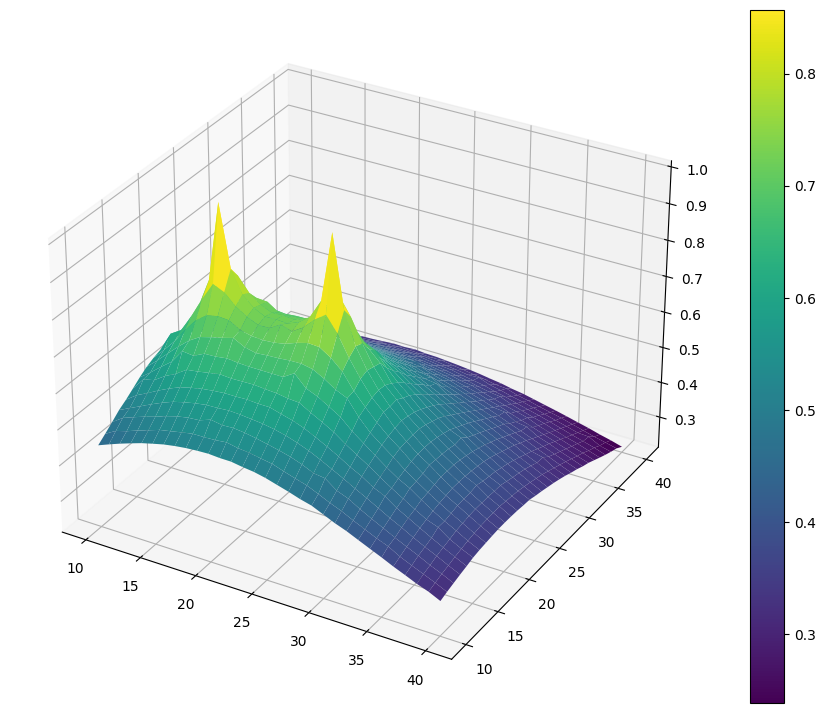

In [3]:
s1 = np.array([15.1, 20.1])
s2 = np.array([25.1, 20.1])
x = np.arange(10,41)
y = np.arange(10,41)
X, Y = np.meshgrid(x, y)
t = 100
vel = 1
dt = .001
mf_path = 20 # maybe 5 times the wavelength? Apparently 20-60 in volcanic regions
# According to Gabrielli et al. (2020) Q_S^-1 = 0.0014, for 3 Hz, mfp about 38 km
#  Q_s = 2*pi*f*mf_path/v , mf_path = Q_s*v/(2*pi*f)
mf_path = vel/(2*np.pi*0.0014*3)
print(mf_path)

K = sensitivity_kernel(s1, s2, x, y, t, dt, vel, mf_path)
# K[10, 10] = 1

from matplotlib import pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 9))
surf = ax.plot_surface(X, Y, K/K.max(), linewidth=0, antialiased=True, cmap='viridis')
plt.colorbar(surf)


## Actual Least-Squares Inversion

In [4]:
from typing import List, Tuple, Optional, Iterator, Iterable
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl
from obspy.geodetics.base import locations2degrees as loc2deg
from obspy.geodetics.base import degrees2kilometers as deg2km
from obspy import UTCDateTime

from seismic.monitor.dv import DV


def data_variance(
    corr: np.ndarray | float, bandwidth: float, tw: Tuple[float, float],
        freq_c: float) -> np.ndarray | float:
    """
    Compute the variance of the velocity change data based on the coherence
    value between stretched reference trace and correlation function.

    (see Obermann et. al. 2013)

    :param corr: coherence
    :type corr: np.ndarray | float
    :param bandwidth: Bandwidth between low and highpass filter
    :type bandwidth: float
    :param tw: Time Window used for the dv/v computation. In the form
        Tuple[tw_start, tw_end]
    :type tw: Tuple[float, float]
    :param freq_c: Centre frequency.
    :type freq_c: float
    :return: Data Variance in the same shape as corr
    :rtype: np.ndarray | float
    """
    T = 1/bandwidth
    p1 = np.sqrt(1-corr)/(2*corr)
    nom = 6*np.sqrt(np.pi/2)*T
    denom = (2*np.pi*freq_c)**2*(tw[1]**3-tw[0]**3)
    p2 = np.sqrt(nom/denom)
    return p1*p2


def compute_cm(
    scaling_factor: float, corr_len: float, std_model: float,
        dist: np.ndarray) -> np.ndarray:
    """
    Computes the model variance for the dv/v grid.

    (see Obermann et. al. 2013)

    :param scaling_factor: Scaling factor, dependent on the cell length.
        (e.g., 1*cell_length)
    :type scaling_factor: float
    :param corr_len: Length over which the parameters are related (high
        value means stronger smoothing).
    :type corr_len: float
    :param std_model: A-priori standard deviation of the model. Corresponds
        to the best agreement between 1) the stability of the model for the
        velocity variations and 2) the minimised difference between the model
        predictions (output of the forward problem) and the data.
        Can be estimated via the L-curve criterion (see Hansen 1992)
    :type std_model: float
    :param dist: Matrix containing distance between the two cells i and j.
        Will always be 0 on the diagonal where i==j.
    :type dist: np.ndarray
    :return: Returns the model variance in the same shape as dist. I.e.,
        NxN where N is the number of station combinations.
    :rtype: np.ndarray
    """
    p1 = (std_model*scaling_factor/corr_len)**2
    smooth = np.exp(-dist/corr_len)
    return p1*smooth


def geo2cart(
    lat: np.ndarray | float, lon: np.ndarray | float, lat0: float
        ) -> Tuple[np.ndarray | float, np.ndarray | float]:
    """
    Convert geographic coordinates to Northing and Easting for a local grid.

    .. seealso::
        http://wiki.gis.com/wiki/index.php/Easting_and_northing

    :param lat: Latitude(s)
    :type lat: np.ndarray | float
    :param lon: Longitude(s)
    :type lon: np.ndarray | float
    :param lat0: Latitude of the lower left corner of the grid
    :type lat0: float
    :return: A tuple holding (Easting, Northing) in km and in the same shape
        as ``lat`` and ``lon``.
    :rtype: Tuple[np.ndarray, np.ndarray]
    """
    # Northing
    y = deg2km(lat)
    # easting
    x = deg2km(loc2deg(lat0, lon, lat0, 0))
    if isinstance(lon, float):
        if lon < 0:
            x = -x
    else:
        x[lon < 0] *= -1
    return x, y


class DVGrid(object):
    """
    Object to handle spatially gridded DV objects.
    """
    def __init__(
            self, lat0: float, lon0: float, res: float, x: float, y: float):
        """
        Initialises the grid to compute dv/v on. The grid will be in
        Cartesian coordinates with the lower left boarder (lon0, lat0)
        as reference point.

        :param lat0: Minimum latitude on the grid.
        :type lat0: float
        :param lon0: Minimum longitude on the grid
        :type lon0: float
        :param res: Resolution in km
        :type res: float
        :param x: Eastwards extent of the grid in km
        :type x: float
        :param y: Northwards extent of the grid in km
        :type y: float
        """
        self.lat0 = lat0
        self.lon0 = lon0

        # Compute local grid
        x0, y0 = geo2cart(lat0, lon0, lat0)
        self.xaxis = np.arange(x0, x0 + x + res, res)
        self.yaxis = np.arange(y0, y0 + y + res, res)
        self.res = res
        self.xgrid, self.ygrid = np.meshgrid(self.xaxis, self.yaxis)
        self.xf = self.xgrid.flatten()
        self.yf = self.ygrid.flatten()
        self.dist = None

    def compute_dv_grid(
        self, dvs: Iterator[DV], utc: UTCDateTime, tw: Tuple[float, float],
        dt: float, vel: float, mf_path: float, scaling_factor: float,
        corr_len: float, std_model: float, freq0: float, freq1: float,
            compute_resolution: bool = False) -> np.ndarray:
        """
        Perform a linear least-squares inversion of station specific velocity
        changes (dv/v) at time ``t``.

        The algorithm will perform the following steps:
        1. Computes the sensitivity kernels for each station pair.
        2. Computes model and data variance.
        3. Inverts the velocity changes onto a flattened grid.

        .. note::
            All computations are performed on a flattened grid, so that the
            grid is actually just one-dimensional. The return value is
            reshaped onto the shape of self.xgrid.

        .. warning::
            Low values for ``dt`` can produce artefacts. Very high values
            lead to a drastically increased computational cost.

        :param dvs: The :class:``~seismic.monitor.dv.DV`` objects to use.
            Note that the input can be an iterator, so that not actually all
            dvs have to be loaded into RAM at the same time.
        :type dvs: Iterator[DV]
        :param utc: Time at which the velocity changes should be inverted.
            Has to be covered by the ``DV`` objects.
        :type utc: UTCDateTime
        :param tw: Time window used to evaluate the velocity changes.
            Given in the form Tuple[tw_start, tw_end].
        :type tw: Tuple[float, float]
        :param dt: Temporal resolution to perform the numerical integration on.
            Note that low values can lead to artefacts in the sensitivity
            kernel. High values will increase the computational demand
            drastically.
        :type dt: float
        :param vel: Wave velocity in the region.
        :type vel: float
        :param mf_path: Mean free path (i.e., distance until which a wave
            entirely loses it's directional information).
        :type mf_path: float
        :param scaling_factor: Scaling factor, dependent on the cell length.
            (e.g., 1*cell_length)
        :type scaling_factor: float
        :param corr_len: Length over which the parameters are related (high
            value means stronger smoothing).
        :type corr_len: float
        :param std_model: A-priori standard deviation of the model. Corresponds
            to the best agreement between 1) the stability of the model for the
            velocity variations and 2) the minimised difference between the
            model predictions (output of the forward problem) and the data.
            Can be estimated via the L-curve criterion (see Hansen 1992)
        :type std_model: float
        :param freq0: high-pass frequency of the used bandpass filter.
        :type freq0: float
        :param freq1: low-pass frequency of the used bandpass filter.
        :type freq1: float
        :param compute_resolution: Compute the resolution matrix?
            Will be saved in self.resolution
        :type compute_resolution: bool, defaults to False
        :raises ValueError: For times that are not covered by the dvs
            time-series.
        :return: The dv-grid (with corresponding coordinates in
            self.xgrid and self.ygrid or self.xaxis and self.yaxis,
            respectively)
        :rtype: np.ndarray
        """
        vals, corrs, slat0, slon0, slat1, slon1 = self._extract_info_dvs(
            dvs, utc)
        skernels = self._compute_sensitivity_kernels(
            slat0, slon0, slat1, slon1, (tw[0]+tw[1])/2, dt, vel, mf_path)
        dist = self._compute_dist_matrix()
        # Model variance, smoothed diagonal matrix
        cm = compute_cm(scaling_factor, corr_len, std_model, dist)
        # Data variance, diagonal matrix
        cd = self._compute_cd(skernels, freq0, freq1, tw, corrs)

        # Linear Least-Squares Inversion
        a = np.dot(cm, skernels.T)
        b = np.linalg.inv(np.dot(np.dot(skernels, cm), skernels.T) + cd)
        c = np.array(vals)
        m = np.dot(np.dot(a, b), c)
        # m is the flattened array, reshape onto grid
        self.vel_change = m.reshape(self.xgrid.shape)
        if compute_resolution:
            self.resolution = self._compute_resolution(skernels, a, b)
        return self.vel_change

    def compute_resolution(
        self, dvs: Iterable[DV], utc: UTCDateTime, scaling_factor: float,
        corr_len: float, tw: Tuple[float, float], dt: float,
        std_model: float, vel: float, mf_path: float, freq0: float,
            freq1: float):
        """
        Compute the model resolution of the dv/v model.

        .. seealso::
            Described in the supplement to Obermann (2013)

        .. note::
            Note that it's significantly faster to perform a joint inversion
            or a gridded dv/v and resolution rather than performing them
            separately.

        :param dvs: The :class:``~seismic.monitor.dv.DV`` objects to use.
            Note that the input can be an iterator, so that not actually all
            dvs have to be loaded into RAM at the same time.
        :type dvs: Iterator[DV]
        :param utc: Time at which the velocity changes should be inverted.
            Has to be covered by the ``DV`` objects.
        :type utc: UTCDateTime
        :param tw: Time window used to evaluate the velocity changes.
            Given in the form Tuple[tw_start, tw_end].
        :type tw: Tuple[float, float]
        :param dt: Temporal resolution to perform the numerical integration on.
            Note that low values can lead to artefacts in the sensitivity
            kernel. High values will increase the computational demand
            drastically.
        :type dt: float
        :param vel: Wave velocity in the region.
        :type vel: float
        :param mf_path: Mean free path (i.e., distance until which a wave
            entirely loses it's directional information).
        :type mf_path: float
        :param scaling_factor: Scaling factor, dependent on the cell length.
            (e.g., 1*cell_length)
        :type scaling_factor: float
        :param corr_len: Length over which the parameters are related (high
            value means stronger smoothing).
        :type corr_len: float
        :param std_model: A-priori standard deviation of the model. Corresponds
            to the best agreement between 1) the stability of the model for the
            velocity variations and 2) the minimised difference between the
            model predictions (output of the forward problem) and the data.
            Can be estimated via the L-curve criterion (see Hansen 1992)
        :type std_model: float
        :param freq0: high-pass frequency of the used bandpass filter.
        :type freq0: float
        :param freq1: low-pass frequency of the used bandpass filter.
        :type freq1: float
        :raises ValueError: For times that are not covered by the dvs
            time-series.
        :return: A gridded resolution matrix.
        :rtype: np.ndarray
        """
        cm = compute_cm(
            scaling_factor, corr_len, std_model,
            self.dist or self._compute_dist_matrix())
        _, corrs, slat0, slon0, slat1, slon1 = self._extract_info_dvs(
            dvs, utc)
        skernels = self._compute_sensitivity_kernels(
            slat0, slon0, slat1, slon1, (tw[0]+tw[1])/2, dt, vel, mf_path)
        cd = self._compute_cd(freq0, freq1, tw, corrs)

        # The actual inversion for the resolution
        a = np.dot(cm, skernels.T)
        b = np.linalg.inv(np.dot(np.dot(skernels, cm), skernels.T) + cd)
        self.resolution = self._compute_resolution(skernels, a, b)
        return self.resolution

    def _compute_resolution(
        self, skernels: np.ndarray, a: np.ndarray, b: np.ndarray
            ) -> np.ndarray:
        res = np.dot(np.dot(a, b), skernels)
        self.resolution = res.reshape(self.xgrid.shape)
        return self.resolution

    def _extract_info_dvs(
        self, dvs: Iterable[DV], utc: UTCDateTime
            ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Extract the reqired infos from a iterator over dv.

        :param dvs: station-specific dvs to be used for the inversion
        :type dvs: Iterable[DV]
        :param utc: Time to perform the inversion for
        :type utc: UTCDateTime
        :raises ValueError: if ``utc`` is not covered by dvs
        :return: dv/v estimates, coherency values, latituds_stat1,
            longitudes_stat1, latitudes_stat2, longitudes_stat2.
            All specific for time ``utc``
        :rtype: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        """
        vals, corrs, slat0, slon0, slat1, slon1 = [], [], [], [], [], []
        for dv in dvs:
            if utc < dv.stats.corr_start[0] or utc > dv.stats.corr_end[-1]:
                raise ValueError(
                    f'Time {utc} is outside of the dv time-series'
                )
            ii = np.argmin(abs(np.array(dv.stats.corr_start)-utc))
            val = dv.value[ii]
            corr = dv.corr[ii]
            if np.isnan(val) or np.isnan(corr):
                # No value
                continue
            vals.append(val)
            corrs.append(corr)
            slat0.append(dv.stats.stla)
            slon0.append(dv.stats.stlo)
            slat1.append(dv.stats.evla)
            slon1.append(dv.stats.evlo)
        slat0 = np.array(slat0)
        slon0 = np.array(slon0)
        self._add_stations(slat0, slon0)
        slat1 = np.array(slat1)
        slon1 = np.array(slon1)
        self._add_stations(slat1, slon1)
        vals = np.array(vals)
        corrs = np.array(corrs)
        return vals, corrs, slat0, slon0, slat1, slon1

    def _add_stations(self, lats: Iterable[float], lons: Iterable[float]):
        """
        Add Coordinates of the stations to self (coordinates are converted
        from geographic coordinates to northing and easting).

        :param lats: Station Latitudes
        :type lats: Iterable[float]
        :param lons: Station Longitudes
        :type lons: Iterable[float]
        """
        x, y = geo2cart(np.array(lats), np.array(lons), self.lat0)
        if hasattr(self, 'statx'):
            self.statx = np.hstack((self.statx, x))
            self.staty = np.hstack((self.staty, y))
        else:
            self.statx = np.array(x)
            self.staty = np.array(y)
        coords = [(x, y) for x, y in zip(self.statx, self.staty)]
        coords = list(set(coords))
        self.statx, self.staty = zip(*coords)
        self.statx = np.array(self.statx)
        self.staty = np.array(self.staty)

    def _compute_cd(
        skernels: np.ndarray, freq0: float, freq1: float,
            tw: Tuple[float, float], corrs: np.ndarray) -> np.ndarray:
        """
        Compute the Variance of the data (in matrix form).

        :param skernels: Sensitivity kernel matrix
        :type skernels: np.ndarray
        :param freq0: highpass frequency [Hz]
        :type freq0: float
        :param freq1: lowpass frequency [Hz]
        :type freq1: float
        :param tw: lapse time window used to determine dv/v
        :type tw: Tuple[float, float]
        :param corrs: Coherency values.
        :type corrs: np.ndarray
        :return: A diagonal matrix describing the data variance.
        :rtype: np.ndarray
        """
        return np.eye(len(skernels))*data_variance(
            np.array(corrs), freq1-freq0, tw, (freq1+freq0)/2)

    def _compute_dist_matrix(self) -> np.ndarray:
        """
        Computes the distance from each cell to one another.

        :return: 2D matrix holding distances between cells i and j.
        :rtype: np.ndarray
        """
        self.dist = np.zeros((len(self.xf), len(self.xf)))
        for ii, (xx, yy) in enumerate(zip(self.xf, self.yf)):
            self.dist[ii, :] = np.sqrt((self.xf-xx)**2+(self.yf-yy)**2)
        return self.dist

    def _find_coord(
        self, lat: float | np.ndarray, lon: float | np.ndarray
            ) -> int | np.ndarray:
        """
        Finds a coordinate given in lat, lon on the Cartesian grid and
        return its index

        ..note:: The grid is flattened, so only one index i is returned
            per lat/lon combination

        :param lat: Latitude(s) of the points to determine
        :type lat: float | np.ndarray
        :param lon: Longitude(s) of the points to determine
        :type lon: float | np.ndarray
        :return: The indices of the points. Will have the same length
            as lat/lon (note that either of the two can be a floating point
            number).
        :rtype: int | np.ndarray
        """
        # Find northing and easting of coordinates
        x, y = geo2cart(lat, lon, self.lat0)

        if isinstance(x, float):
            np.argmin(abs(self.xf-x)+abs(self.yf-y))
        ii = np.array(
            [np.argmin(
                abs(self.xf-xx)+abs(self.yf-yy)) for xx, yy in zip(x, y)])
        return ii

    def _compute_sensitivity_kernels(
        self, slat0: np.ndarray, slon0: np.ndarray, slat1: np.ndarray,
        slon1: np.ndarray, t: float, dt: float, vel: float,
            mf_path: float) -> np.ndarray:
        """
        Computes the sensitivity kernels of the station combinations station0
        and station1.

        .. note::
            Station0 and station1 may be identical. Then, the output
            corresponds to the sensitivity kernel of an auto or self
            correlation.

        .. note::
            Handles computations for several dv objects, so the station
            coordinates can be 1D arrays.

        .. warning::
            Low values for ``dt`` can produce artefacts. Very high values
            lead to a drastically increased computational cost.

        :param slat0: Latitude of the first station.
        :type slat0: np.ndarray
        :param slon0: Longitude of the first station
        :type slon0: np.ndarray
        :param slat1: Latitude of the second station.
        :type slat1: np.ndarray
        :param slon1: Longitude of the second station.
        :type slon1: np.ndarray
        :param t: Midpoint of the time lapse window used to evaluate dv/v.
        :type t: float
        :param dt: Resolution in which the numerical integration is
            supposed to be performed. Note that low values produce artefacts.
            High values have a high computational cost.
        :type dt: float
        :param vel: Wave velocity in the medium
        :type vel: float
        :param mf_path: Mean free path (i.e., distance until which a wave
            entirely loses it's directional information).
        :type mf_path: float
        :return: Weighted matrix holding the sensitivity kernel for station i
            on grid j
        :rtype: np.ndarray
        """
        ii0 = self._find_coord(slat0, slon0)
        ii1 = self._find_coord(slat1, slon1)
        skernels = []
        for i0, i1 in zip(ii0, ii1):
            s1 = np.array([self.xf[i0], self.yf[i0]])
            s2 = np.array([self.xf[i1], self.yf[i1]])
            sk = sensitivity_kernel(
                s1, s2, self.xaxis, self.yaxis, t, dt, vel, mf_path)
            skernels.append(sk.flatten())
        self.skernels = self.res**2/t * np.array(skernels)
        return self.skernels

    def plot(
        self, plot_stations: bool = True, cmap: str = 'seismic',
        ax: Optional[mpl.axis.Axis] = None, *args, **kwargs
            ) -> mpl.axis.Axis:
        """
        Simple heatplot of the dv/v grid in Cartesian coordinates.

        :param plot_stations: plot station coordinates, defaults to True
        :type plot_stations: bool, optional
        :param cmap: Colormap to use, defaults to 'seismic'
        :type cmap: str, optional
        :param ax: Axis to plot into, defaults to None
        :type ax: Optional[mpl.axis.Axis], optional
        :return: Returns the axis handle
        :rtype: mpl.axis.Axis
        """
        if not ax:
            plt.figure()
            ax = plt.gca()
        map = ax.imshow(
            -100*self.vel_change, interpolation='none',
            extent=[
                self.xaxis.min(), self.xaxis.max(), self.yaxis.min(),
                self.yaxis.max()],
            cmap=cmap, zorder=0, *args, **kwargs)
        if plot_stations:
            ax.scatter(self.statx, self.staty, marker='v', c='k', s=30)
        plt.colorbar(map, label=r'$\frac{dv}{v}$ [%]')
        plt.xlabel('Easting [km]')
        plt.ylabel('Northing [km]')
        return ax


# Test

In [11]:
from seismic.monitor.dv import read_dv
import glob
dvs = []
dvs.append(read_dv('/home/pm/Documents_sync/PhD/StHelens/dv/resp_removed/xstations_0.5-1.0_wl86400_tw14.0-60_1b_mute_SW_presmooth18d_srw/DV-UW-UW.JUN-SHW.EHZ-EHZ.npz'))
dvs.append(read_dv('/home/pm/Documents_sync/PhD/StHelens/dv/resp_removed/xstations_0.5-1.0_wl86400_tw14.0-60_1b_mute_SW_presmooth18d_srw/DV-CC-UW.STD-HSR.BHE-EHZ.npz'))
dvs.append(read_dv('/home/pm/Documents_sync/PhD/StHelens/dv/resp_removed/xstations_0.5-1.0_wl86400_tw14.0-60_1b_mute_SW_presmooth18d_srw/DV-CC-UW.STD-HSR.BHN-EHZ.npz'))
dvs.append(read_dv('/home/pm/Documents_sync/PhD/StHelens/dv/resp_removed/xstations_0.5-1.0_wl86400_tw14.0-60_1b_mute_SW_presmooth18d_srw/DV-CC-UW.STD-HSR.BHZ-EHZ.npz'))
dvs.append(read_dv('/home/pm/Documents_sync/PhD/StHelens/dv/resp_removed/xstations_0.5-1.0_wl86400_tw14.0-60_1b_mute_SW_presmooth18d_srw/DV-CC-UW.STD-SHW.BHE-EHZ.npz'))

def get_dv():
    files = glob.glob('/home/pm/Documents_sync/PhD/StHelens/dv/resp_removed/xstations_0.5-1.0_wl86400_tw14.0-60_1b_mute_SW_presmooth18d_srw/*.npz')
    for f in files:
        dv = read_dv(f)
        dv.value.fill(-.01)
        yield(dv)

def fake_dv():
    dv = read_dv('/home/pm/Documents_sync/PhD/StHelens/dv/resp_removed/xstations_0.5-1.0_wl86400_tw14.0-60_1b_mute_SW_presmooth18d_srw/DV-UW-UW.JUN-SHW.EHZ-EHZ.npz')
    lats = np.arange(lat0-0.05, lat0+0.3, 0.02)
    lons = np.arange(lon0, lon0 + 0.6, 0.04)
    for ii, lat in enumerate(lats):
        dv.stats.evla = lat
        dv.stats.stla = lats[-ii-1]
        for jj, lon in enumerate(lons):
            dv.stats.evlo = lon
            dv.stats.stlo = lons[-jj-1]
            dv.value.fill((-1)**ii*.01)
            dv.corr.fill(1)
            yield dv

# for dv in dvs:
#     dv.value.fill(-0.01)


In [7]:
from obspy import UTCDateTime

# params for grid
lats = [dv.stats.stla for dv in dvs]
lats.extend([dv.stats.evla for dv in dvs])
lons = [dv.stats.stlo for dv in dvs]
lons.extend([dv.stats.evlo for dv in dvs])
lat0 = min(lats) - .05
lon0 = min(lons) - .1
res = .5  # km
x = 18
y = 28
vel = 1 # km/s
mf_path = vel/(2*np.pi*0.0014*3)
tw = (14, 74)

# time for dv computation
t = UTCDateTime(2014, 10, 1)

In [12]:

dvgrid = DVGrid(lat0, lon0, res, x, y)
dvg = dvgrid.compute_dv_grid(fake_dv(), t, tw, .01, vel, mf_path, res, 3.2e-2, 2, .5, 1)

/tmp/ipykernel_65396/1354221282.py:27: RuntimeWarning: divide by zero encountered in divide
  np.exp(-vel*t/mf_path)/(2*np.pi*dist), nan=0, posinf=1)
/tmp/ipykernel_65396/1354221282.py:29: RuntimeWarning: divide by zero encountered in divide
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_65396/1354221282.py:29: RuntimeWarning: invalid value encountered in divide
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_65396/1354221282.py:29: RuntimeWarning: invalid value encountered in sqrt
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_65396/1354221282.py:30: RuntimeWarning: invalid value encountered in sqrt
  b = (np.sqrt((vel*t)**2-dist**2) - vel*t)/mf_path
/tmp/ipykernel_65396/1354221282.py:33: RuntimeWarning: divide by zero encountered in divide
  return coherent + np.nan_to_num(np.exp(b)*c/a, posinf=1, neginf=1, nan=0)


TypeError: DVGrid._compute_cd() takes 5 positional arguments but 6 were given

In [227]:
# comparison with dt=.1
dvgriddt01 = DVGrid(lat0, lon0, res, x, y)
dvg_dt01 = dvgrid.compute_dv_grid(get_dv(), t, tw, .1, vel, mf_path, res, 3.2e-2, 2, .5, 1)

has attribute!


/tmp/ipykernel_9396/1354221282.py:27: RuntimeWarning: divide by zero encountered in divide
  np.exp(-vel*t/mf_path)/(2*np.pi*dist), nan=0, posinf=1)
/tmp/ipykernel_9396/1354221282.py:29: RuntimeWarning: divide by zero encountered in divide
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_9396/1354221282.py:29: RuntimeWarning: invalid value encountered in divide
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_9396/1354221282.py:29: RuntimeWarning: invalid value encountered in sqrt
  a = 2*np.pi*mf_path*vel*t*np.sqrt(1 - dist**2/(vel*t)**2)
/tmp/ipykernel_9396/1354221282.py:30: RuntimeWarning: invalid value encountered in sqrt
  b = (np.sqrt((vel*t)**2-dist**2) - vel*t)/mf_path
/tmp/ipykernel_9396/1354221282.py:33: RuntimeWarning: divide by zero encountered in divide
  return coherent + np.nan_to_num(np.exp(b)*c/a, posinf=1, neginf=1, nan=0)


shape of cm  (2601, 2601)
shape of skernels  (304, 2601)
shape of cd  (304, 304)
shape of dv_app  (304,)


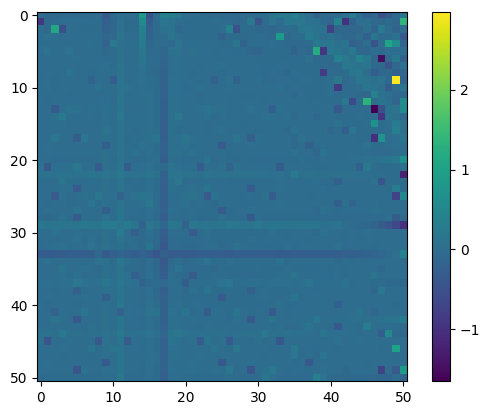

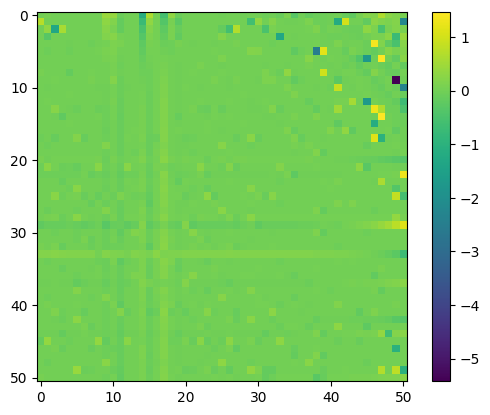

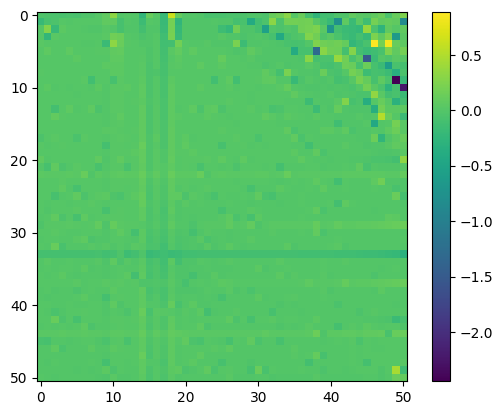

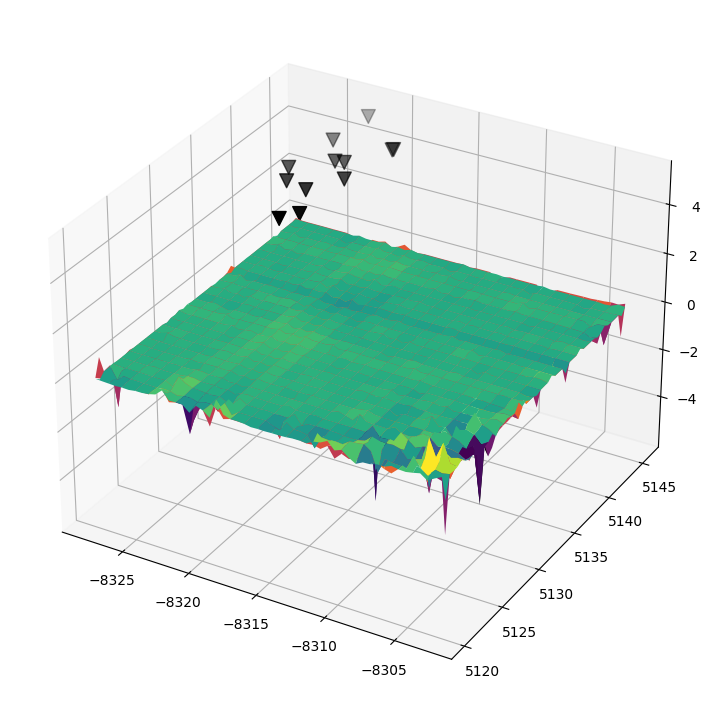

In [239]:
map = plt.imshow(dvg.reshape(dvgrid.xgrid.shape)-dvg_dt01.reshape(dvgrid.xgrid.shape))
plt.colorbar(map)

plt.figure()
map = plt.imshow(dvg_dt01.reshape(dvgrid.xgrid.shape))
plt.colorbar(map)
plt.figure()
map = plt.imshow(dvg.reshape(dvgrid.xgrid.shape))
plt.colorbar(map)
from matplotlib import pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 9))
surf = ax.plot_surface(dvgrid.xgrid, dvgrid.ygrid, dvg.reshape(dvgrid.xgrid.shape), linewidth=0, antialiased=True, cmap='seismic')
surf2 = ax.plot_surface(dvgrid.xgrid, dvgrid.ygrid, dvg_dt01.reshape(dvgrid.xgrid.shape), linewidth=0, antialiased=True, cmap='seismic')


ax.scatter(np.array(dvgrid.statx), np.array(dvgrid.staty), 5*np.ones_like(dvgrid.statx), s=100, c='k', marker='v')
ax.scatter(x_helens, y_helens, s=150, marker='^', c='r')

Text(0.5, 0.5, 'Northing [km]')

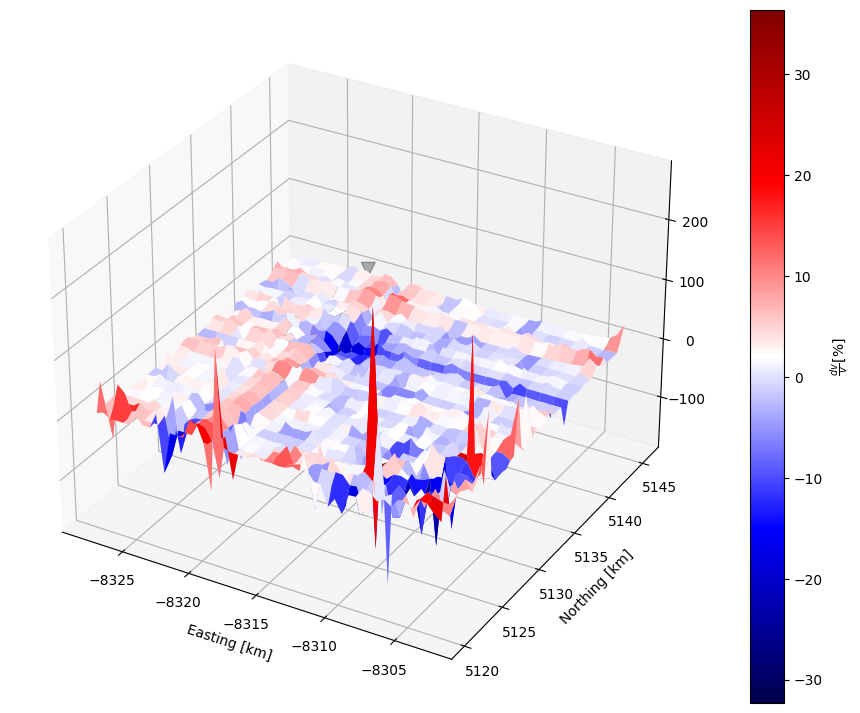

In [7]:
# test with altered values
x_helens, y_helens = geo2cart(46.1914, -122.1956, dvgrid.lat0)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 9))
surf = ax.plot_surface(dvgrid.xgrid, dvgrid.ygrid, -100*dvgrid.vel_change, linewidth=0, antialiased=True, cmap='seismic')
ax.scatter(np.array(dvgrid.statx), np.array(dvgrid.staty), 5*np.ones_like(dvgrid.statx), s=100, c='k', marker='v')
ax.scatter(x_helens, y_helens, s=150, marker='^', c='r')

plt.colorbar(surf, label=r'$\frac{dv}{v}$[%]')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')


Text(0, 0.5, 'Northing [km]')

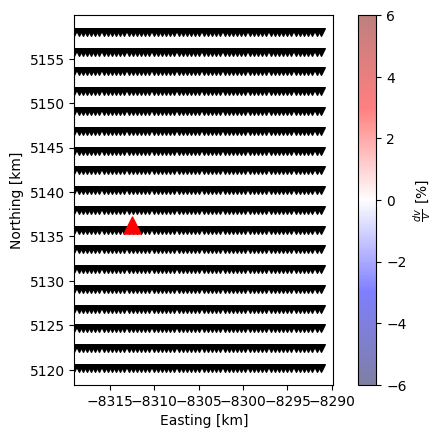

In [44]:
x_helens, y_helens = geo2cart(46.1914, -122.1956, dvgrid.lat0)
map = plt.imshow(
    -100*dvgrid.vel_change, interpolation='none', extent=[dvgrid.xaxis.min(),
    dvgrid.xaxis.max(), dvgrid.yaxis.min(), dvgrid.yaxis.max()],
    cmap='seismic', vmin=-6, vmax=6, alpha=.5, zorder=0)
plt.scatter(dvgrid.statx, dvgrid.staty, marker='v', c='k', s=30)
plt.scatter(x_helens, y_helens, s=150, marker='^', c='r')
# plt.xlim(dvgrid.statx.min()-2, dvgrid.statx.max()+2)
# plt.ylim(dvgrid.staty.min()-2, dvgrid.staty.max()+2)
plt.colorbar(map, label=r'$\frac{dv}{v}$ [%]')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')

# stats = []
# for dv in get_dv():
#     ii = np.argmin(np.array(dv.stats.corr_start)-t)
#     if np.isnan(dv.value[ii]):
#         continue
#     stats.append(dv.stats.station)
# stats = list(set(stats))
# print(stats)


In [27]:
stat0 = [s.split('-')[0] for s in stats]
stat1 = [s.split('-')[1] for s in stats]
statsn = []
statsn += stat0 + stat1
statsn = list(set(statsn))

In [29]:
print(len(statsn))
print(len(dvgrid.statx))

15
13


Text(0.5, 0.5, 'Northing [km]')

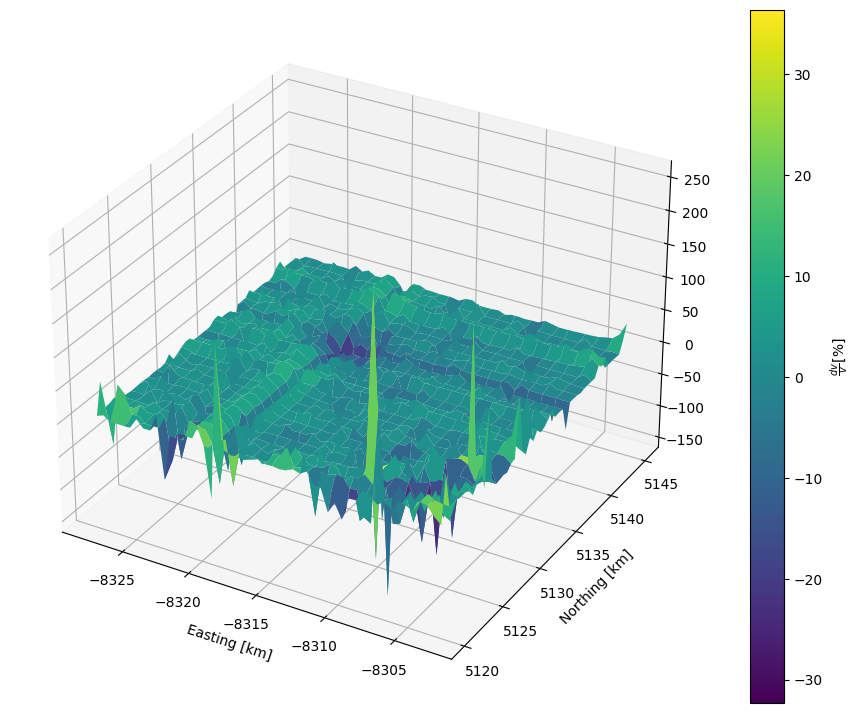

In [10]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 9))
surf = ax.plot_surface(dvgrid.xgrid, dvgrid.ygrid, -100*dvgrid.vel_change, linewidth=0, antialiased=True, cmap='viridis')
plt.colorbar(surf, label=r'$\frac{dv}{v}$[%]')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')
